## Pipeline

* What is churn data?
A. Customer <b>Churn</b> is a metric used to quantify the number of customers who have either unsubscribed or canceled their service contract.

#### Problem Statement
* About Data - Rental bike usage data
* We wanted to predict churn( customers leaving your product)

In [152]:
import wikipedia 
result = wikipedia.page('India')
print(result.summary)

India (Hindi: Bhārat), officially the Republic of India (Hindi: Bhārat Gaṇarājya), is a country in South Asia. It is the second-most populous country, the seventh-largest country by area, and the most populous democracy in the world. Bounded by the Indian Ocean on the south, the Arabian Sea on the southwest, and the Bay of Bengal on the southeast, it shares land borders with Pakistan to the west; China, Nepal, and Bhutan to the north; and Bangladesh and Myanmar to the east. In the Indian Ocean, India is in the vicinity of Sri Lanka and the Maldives; its Andaman and Nicobar Islands share a maritime border with Thailand and Indonesia.
Modern humans arrived on the Indian subcontinent from Africa no later than 55,000 years ago.
Their long occupation, initially in varying forms of isolation as hunter-gatherers, has made the region highly diverse, second only to Africa in human genetic diversity. Settled life emerged on the subcontinent in the western margins of the Indus river basin 9,000 y

In [67]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.pipeline import make_pipeline

In [2]:
churn_data = pd.read_csv('https://raw.githubusercontent.com/edyoda/data-science-complete-tutorial/master/Data/churn.csv.txt', parse_dates=['last_trip_date','signup_date'])

In [3]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
luxury_car_user           50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


### Is there any churn column in data?
* Many times, target columns is directly not available.
* It has to be derived from feature columns
* From the data, we need to identify the date on whcih the data was downloaded

In [4]:
churn_data.last_trip_date.max() # got date of last time services used

Timestamp('2014-07-01 00:00:00')

In [5]:
last_date = churn_data.last_trip_date.max()

In [6]:
cut_off_date = last_date - datetime.timedelta(30)

In [7]:
cut_off_date # got last month starting date

Timestamp('2014-06-01 00:00:00')

* If an user didn't come after cutoff date he/she is considered as churn

In [8]:
churn_data['churn'] = churn_data.last_trip_date.map(lambda d: 'Not churn' if d > cut_off_date else 'churn')

In [9]:
churn_data.sample(5)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn
46054,1.38,4.8,4.5,1.13,Winterfell,2014-03-16,iPhone,2014-01-28,50.0,0,False,0.0,churn
5224,10.50,5.0,3.5,1.00,Winterfell,2014-01-25,iPhone,2014-01-20,0.0,3,True,66.7,churn
9197,1.57,4.8,3.7,1.00,Astapor,2014-06-28,iPhone,2014-01-07,0.0,2,False,75.0,Not churn
7624,4.23,5.0,NaN,1.00,Astapor,2014-06-27,iPhone,2014-01-29,0.0,1,True,100.0,Not churn
16669,8.47,4.2,4.3,1.00,Winterfell,2014-07-01,iPhone,2014-01-30,0.0,1,True,38.5,Not churn


In [10]:
churn_data.dtypes

avg_dist                         float64
avg_rating_by_driver             float64
avg_rating_of_driver             float64
avg_surge                        float64
city                              object
last_trip_date            datetime64[ns]
phone                             object
signup_date               datetime64[ns]
surge_pct                        float64
trips_in_first_30_days             int64
luxury_car_user                     bool
weekday_pct                      float64
churn                             object
dtype: object

In [11]:
churn_data['subscription_days'] = churn_data.last_trip_date - churn_data.signup_date

* timedelta to day conversion

In [12]:
churn_data['subscription_days'] = churn_data.subscription_days.dt.days

In [13]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
luxury_car_user           50000 non-null bool
weekday_pct               50000 non-null float64
churn                     50000 non-null object
subscription_days         50000 non-null int64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(2), object(3)
memory usage: 5.0+ MB


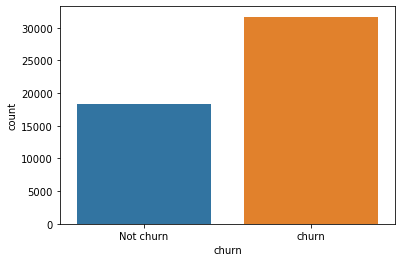

In [14]:
sns.countplot(x ='churn', data = churn_data)

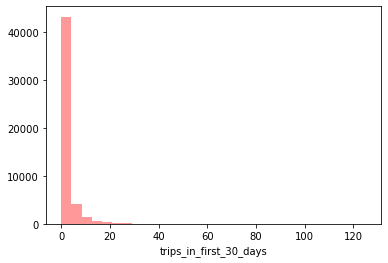

In [15]:
sns.distplot(churn_data.trips_in_first_30_days, kde = False, color ='red', bins = 30)

In [24]:
feature_data = churn_data.drop(columns=['churn','last_trip_date','signup_date'])
target_data = churn_data.churn

In [25]:
feature_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
luxury_car_user           50000 non-null bool
weekday_pct               50000 non-null float64
subscription_days         50000 non-null int64
dtypes: bool(1), float64(6), int64(2), object(2)
memory usage: 3.9+ MB


#### Split Data into different types
* Here we will split the data in same types of groups

In [17]:
# float, we take bool and float together
float_churn_data = churn_data.select_dtypes(include=['float'])

In [18]:
float_churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
avg_dist                50000 non-null float64
avg_rating_by_driver    49799 non-null float64
avg_rating_of_driver    41878 non-null float64
avg_surge               50000 non-null float64
surge_pct               50000 non-null float64
weekday_pct             50000 non-null float64
dtypes: float64(6)
memory usage: 2.3 MB


In [19]:
# int data
int_churn_data = churn_data.select_dtypes(include=['int64'])

In [20]:
int_churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
trips_in_first_30_days    50000 non-null int64
subscription_days         50000 non-null int64
dtypes: int64(2)
memory usage: 781.4 KB


In [26]:
# categorical 
cat_churn_data = churn_data[['city','phone']]

In [27]:
cat_churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
city     50000 non-null object
phone    49604 non-null object
dtypes: object(2)
memory usage: 781.4+ KB


#### Now we fill makes pipeline 
* For different type of data, have different pipeline
* In each pipeline, have imputers to handle missing data

In [32]:
float_pipeline = make_pipeline(SimpleImputer(strategy='median'),MinMaxScaler())

In [33]:
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),OrdinalEncoder())

In [34]:
int_pipeline = make_pipeline(MinMaxScaler())

#### Use ColumnTransformer
* Combine the pipelines using column transformer

In [42]:
preprocessor = make_column_transformer(
    (int_pipeline, int_churn_data.columns),
    (cat_pipeline, cat_churn_data.columns),
    (float_pipeline, float_churn_data.columns)
)

In [43]:
target_data.value_counts() # values seems good, if the confusion matrix will not good then we will use imblearn

churn        31690
Not churn    18310
Name: churn, dtype: int64

#### Create bigger pipeline using columntransforner & estimator
* First We will use RandomForestClassifier

In [44]:
pipeline = make_pipeline(preprocessor,RandomForestClassifier())

* Split the data into train & test

In [45]:
trainX, testX, trainY, testY = train_test_split(churn_data.drop(columns=['churn']), churn_data.churn)

#### Fit the model using pipeline

In [46]:
pipeline.fit(trainX, trainY)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['trips_in_first_30_days', 'subscription_days'], dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  Index(['city', 'phone'], dtype='object')),
                                                 ('pipeline-3',
                   

In [47]:
pipeline.score(testX,testY)

0.95584

In [48]:
# checking the confusion matrix
confusion_matrix(testY,pipeline.predict(testX))

array([[4323,  222],
       [ 330, 7625]], dtype=int64)

In [49]:
gs = GridSearchCV(pipeline, param_grid={'randomforestclassifier__n_estimators':[100,300]},cv=5,n_jobs=4)

In [50]:
gs.fit(trainX,trainY)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         Index(['trips_in_first_30_days', 'subscription_days'], dtype='object')),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordinalencoder',
                                      

In [51]:
gs.best_score_

0.95928

In [52]:
gs.best_params_

{'randomforestclassifier__n_estimators': 300}

* Now test will the all models together

In [54]:
for name,estimator in zip(['Random Forest','Gaussian NB','Logistic Regression'],[RandomForestClassifier(n_estimators=100),GaussianNB(),LogisticRegression()]):
    pipeline = make_pipeline(preprocessor,estimator)
    pipeline.fit(trainX,trainY)
    print(name, pipeline.score(testX,testY))

Random Forest 0.9556
Gaussian NB 0.9248
Logistic Regression 0.95448


* RandomForest is scoring High

### Furthur Fine Tunning
* Feature Selection
* Balancing Data
* More Hyper-parameter Tunning

In [58]:
from imblearn.pipeline import make_pipeline

In [59]:
pipeline = make_pipeline(preprocessor,RandomForestClassifier())

In [60]:
pipeline.fit(trainX,trainY)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['trips_in_first_30_days', 'subscription_days'], dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  Index(['city', 'phone'], dtype='object')),
                                                 ('pipeline-3',
                   

In [61]:
pipeline.score(testX,testY)

0.95608

In [62]:
# checking the confusion matrix
confusion_matrix(testY,pipeline.predict(testX))

array([[4322,  223],
       [ 326, 7629]], dtype=int64)